# HVAC Loops

## Conceptual Introduction to HVAC Loops

Eppy builds threee kinds of loops for the energyplus idf file:

1. Plant Loops
2. Condensor Loops
3. Air Loops

All loops have two halves:

1. Supply side
2. Demand Side

The supply side provides the energy to the demand side that needs the energy. So the end-nodes on the supply side connect to the end-nodes on the demand side. 

The loop is made up of branches connected to each other. A single branch can lead to multiple branches through a **splitter** component. Multiple branches can lead to a single branch through a **mixer** component. 

Each branch is made up of components connected in series (in a line)

Eppy starts off by building the shape or topology of the loop by connecting the branches in the right order. The braches themselves have a single component in them, that is just a place holder. Usually it is a pipe component. In an air loop it would be a duct component.

The shape of the loop for the supply or demand side is quite simple. 

It can be described in the following manner for the supply side

- The supply side starts single branch leads to a splitter
- The splitter leads to multiple branches
- these multiple branches come back and join in a mixer
- the mixer leads to a single branch that becomes end of the suppply side

For the demand side we have:

- The demand side starts single branch leads to a splitter
- The splitter leads to multiple branches
- these multiple branches come back and join in a mixer
- the mixer leads to a single branch that becomes end of the demand side

The two ends of the supply side connect to the two ends of the demand side.


Diagramtically the the two sides of the loop will look like this::



In eppy you could embody this is a list


In [1]:
supplyside = ['start_brandh',   [  'branch1',   'branch2',   'branch3'],   'end_branch']
demandside = ['d_start_brandh', ['d_branch1', 'd_branch2', 'd_branch3'], 'd_end_branch']


Eppy will build the build the shape/topology of the loop using the two lists above. Each branch will have a placeholder component, like a pipe or a duct::

Now we will have to replace the placeholder with the real components that make up the loop. For instance, branch1 should really have a pre-heat coil leading to a supply fan leading to a cooling coil leading to a heating coil::

Eppy lets you build a new branch and you can replace branch1 with new_branch

In this manner we can build up the entire loop with the right components, once the initial toplogy is right

## Building a Plant loops

Eppy can build up the topology of a plant loop using single pipes in a branch.  Once we do that the simple branch in the loop we have built can be replaced with a more complex branch.

Let us try this out ans see how it works.

### Building the topology of the loop

In [2]:
# you would normaly install eppy by doing
# python setup.py install
# or
# pip install eppy
# or
# easy_install eppy

# if you have not done so, uncomment the following three lines
import sys
# pathnameto_eppy = 'c:/eppy'
pathnameto_eppy = '../'
sys.path.append(pathnameto_eppy) 


In [3]:
from eppy.modeleditor import IDF
from eppy import hvacbuilder

from io import StringIO
iddfile = "../eppy/resources/iddfiles/Energy+V7_0_0_036.idd"
IDF.setiddname(iddfile)


In [4]:
# make the topology of the loop
idf = IDF(StringIO('')) # makes an empty idf file in memory with no file name
loopname = "p_loop"
sloop = ['sb0', ['sb1', 'sb2', 'sb3'], 'sb4'] # supply side of the loop
dloop = ['db0', ['db1', 'db2', 'db3'], 'db4'] # demand side of the loop
hvacbuilder.makeplantloop(idf, loopname, sloop, dloop)
idf.saveas("hhh1.idf")


We have made plant loop and saved it as hhh1.idf.  
Now let us look at what the loop looks like.  


### Diagram of the loop

Let us use the script "eppy/useful_scripts/loopdiagrams.py" to draw this diagram

See [Generating a Loop Diagram](useful_scripts.html#loopdiagram-py) page for details on how to do this

Below is the diagram for this simple loop

*Note: the supply and demnd sides are not connected in the diagram, but shown seperately for clarity*

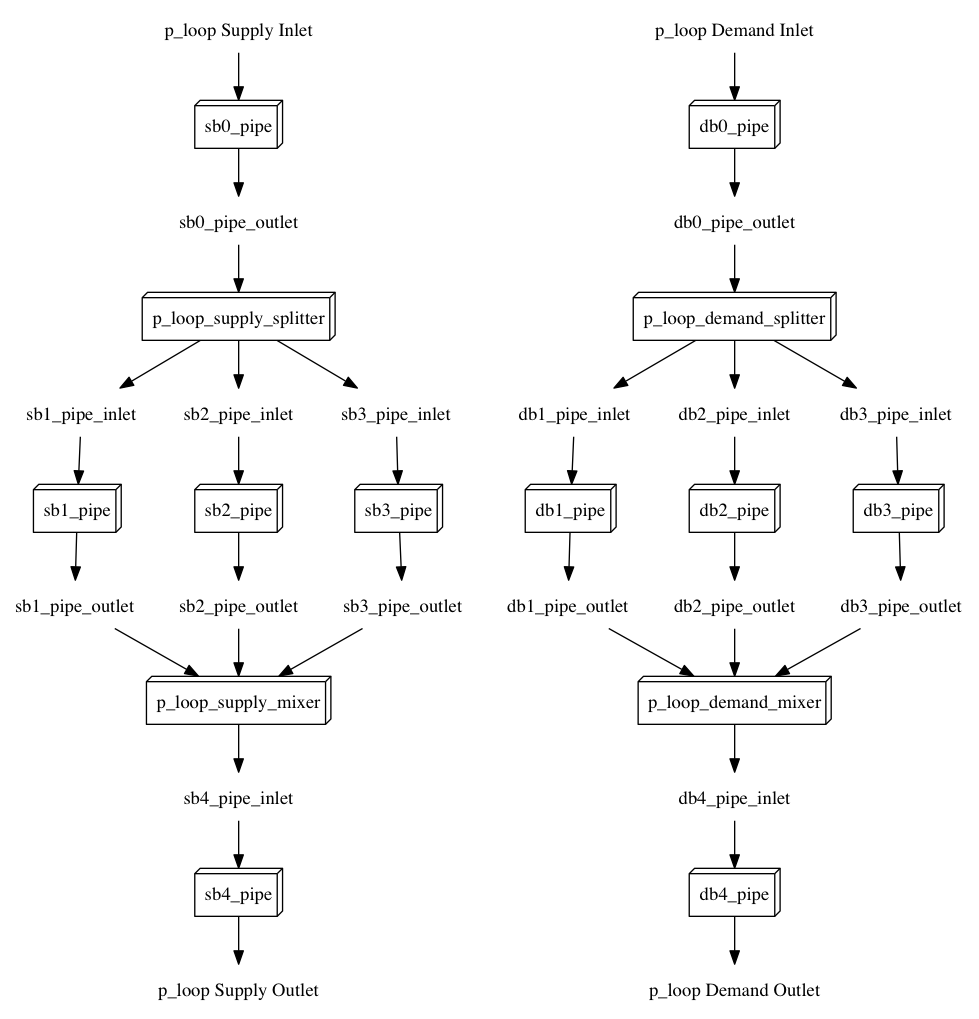

In [5]:
import ex_inits #no need to know this code, it just shows the image below
for_images = ex_inits
for_images.display_png(for_images.plantloop1) # display the image below


### Modifying the topology of the loop

Let us make a new branch and replace the exisiting branch 

The existing branch name is "sb0" and it contains a single pipe component sb0_pipe.

Let us replace it with a branch that has a chiller that is connected to a pipe which is turn connected to another pipe. So the connections in the new branch would look like "chiller-> pipe1->pipe2"

In [6]:
# make a new branch chiller->pipe1-> pipe2

# make a new pipe component
pipe1 = idf.newidfobject("PIPE:ADIABATIC", 'np1')

# make a new chiller
chiller = idf.newidfobject("Chiller:Electric".upper(), 'Central_Chiller')

# make another pipe component
pipe2 = idf.newidfobject("PIPE:ADIABATIC", 'np2')

# get the loop we are trying to modify
loop = idf.getobject('PLANTLOOP', 'p_loop') # args are (key, name)
# get the branch we are trying to modify
branch = idf.getobject('BRANCH', 'sb0') # args are (key, name)
listofcomponents = [chiller, pipe1, pipe2] # the new components are connected in this order


../eppy/modeleditor.py:757: UserWarning: The aname parameter should no longer be used.
  warnings.warn("The aname parameter should no longer be used.", UserWarning)


Now we are going to try to replace **branch** with the a branch made up of **listofcomponents**

- We will do this by calling the function replacebranch
- Calling replacebranch can throw an exception `WhichLoopError`
- In a moment, you will see why this exception is important

In [7]:
try:
    newbr = hvacbuilder.replacebranch(idf, loop, branch, listofcomponents, fluid='Water')
except hvacbuilder.WhichLoopError as e:
    print(e)


Where should this loop connect ?
CHILLER:ELECTRIC - Central_Chiller
['Chilled_Water_', 'Condenser_', 'Heat_Recovery_']



The above code throws the exception. It says that the idfobject `CHILLER:ELECTRIC - Central_Chiller` has three possible connections. The chiller has inlet outlet nodes for the following

- Chilled water
- Condenser
- Heat Recovery

eppy does not know which one to connect to, and it needs your help. We know that the chiller needs to be connected to the chilled water inlet and outlet. Simply copy `Chilled_Water_` from the text in the exception and paste as shown in the code below. (make sure you copy it exactly. eppy is a little nerdy about that)

In [8]:
# instead of passing chiller to the function, we pass a tuple (chiller, 'Chilled_Water_').
# This lets eppy know where the connection should be made.
# The idfobject pipe does not have this ambiguity. So pipes do not need this extra information
listofcomponents = [(chiller, 'Chilled_Water_'), pipe1, pipe2]

try:
    newbr = hvacbuilder.replacebranch(idf, loop, branch, listofcomponents, fluid='Water')
except Exception as e:
    print(e)
else: # else will run only if the try suceeds
    print("no exception was thrown")

idf.saveas("hhh_new.idf")


no exception was thrown


*Tagential note*: The `"try .. except .. else"` statement is useful here. If you have not run across it before, take a look at these two links

- http://shahriar.svbtle.com/the-possibly-forgotten-optional-else-in-python-try-statement
- https://docs.python.org/2/tutorial/errors.html

We have saved this as  file "hhh_new.idf".  
Let us draw the diagram of this file.  (run this from eppy/eppy folder)

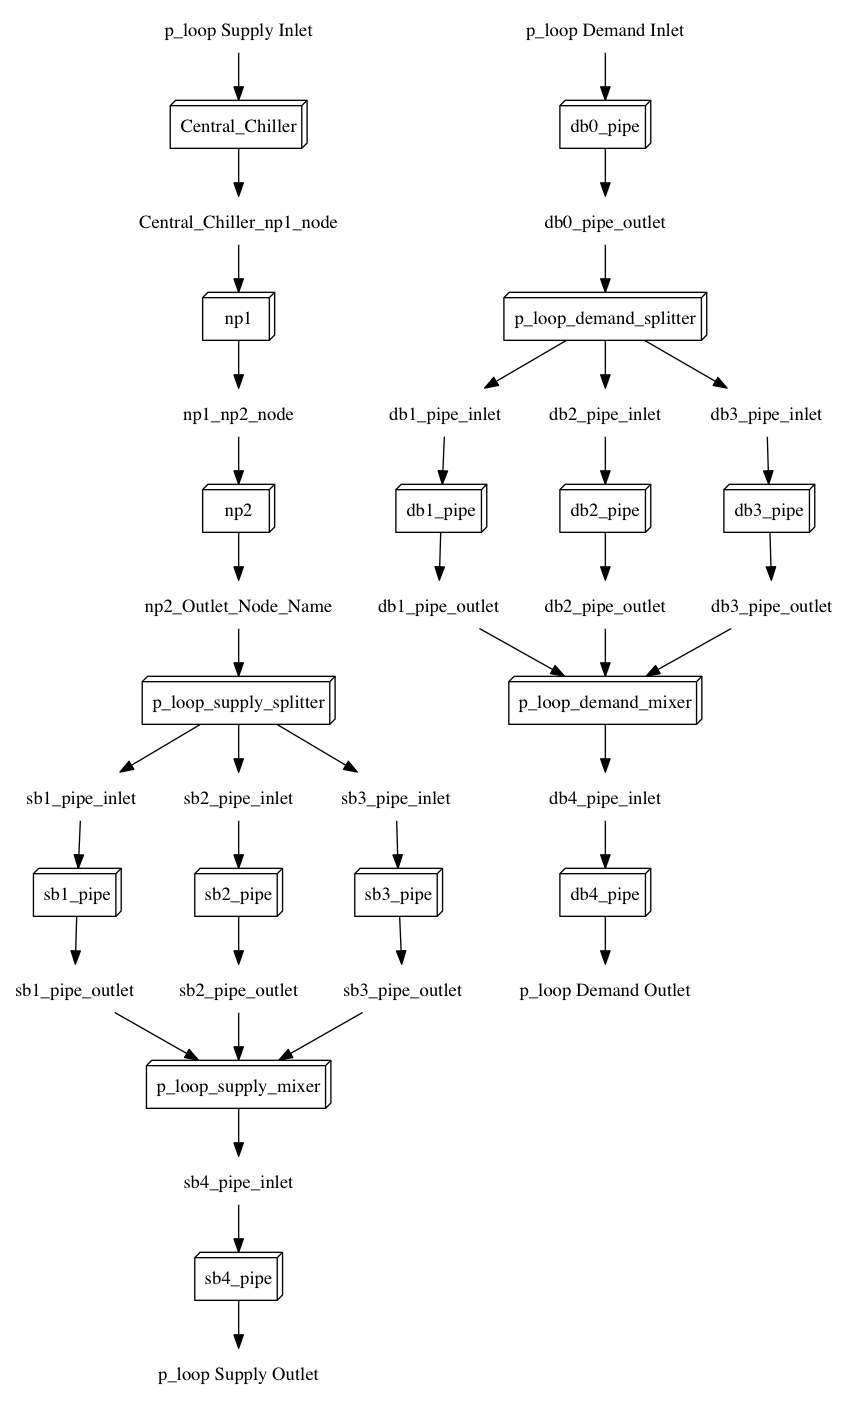

In [9]:
import ex_inits #no need to know this code, it just shows the image below
for_images = ex_inits
for_images.display_png(for_images.plantloop2) # display the image below


This diagram shows the new components in the branch

#### Work flow with `WhichLoopError`

When you are writing scripts don't bother to use `try .. except` for `WhichLoopError`. 

- Simply allow the exception to be raised. 
- Use the information in the exception to update your code
- You may have to do this a couple of times in your script.
- In a sense you are letting eppy tell you how to update the script.

*Question:* I am writing an application using eppy, not just a script. The above workflow does not work for me

*Response:* Aha ! If that is the case, open an issue in [github/eppy](https://github.com/santoshphilip/eppy). We are lazy people. We don't write code unless it is needed :-)

### Traversing the loop

It would be nice to move through the loop using functions "nextnode()" and "prevnode()"

Eppy indeed has such functions

Let us try to traverse the loop above. 

In [12]:
# to traverse the loop we are going to call some functions ex_loopdiagrams.py, 
# the program that draws the loop diagrams.
from eppy.useful_scripts import loopdiagram
fname = 'hhh_new.idf'
iddfile = '../eppy/resources/iddfiles/Energy+V8_0_0.idd'
edges = loopdiagram.getedges(fname, iddfile)
# edges are the lines that draw the nodes in the loop. 
# The term comes from graph theory in mathematics


The above code gets us the edges of the loop diagram. Once we have the edges, we can traverse through the diagram. Let us start with the "Central_Chiller" and work our way down.

In [13]:
from eppy import walk_hvac
firstnode = "Central_Chiller"
nextnodes = walk_hvac.nextnode(edges, firstnode)
print(nextnodes)


['np1']


In [14]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


['np2']


In [15]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


['p_loop_supply_splitter']


In [16]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


['sb1_pipe', 'sb2_pipe', 'sb3_pipe']


This leads us to three components -> ['sb1_pipe', 'sb2_pipe', 'sb3_pipe']. Let us follow one of them

In [17]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


['p_loop_supply_mixer']


In [18]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


['sb4_pipe']


In [19]:
nextnodes = walk_hvac.nextnode(edges, nextnodes[0])
print(nextnodes)


[]


We have reached the end of this branch. There are no more components. 

We can follow this in reverse using the function prevnode()

In [20]:
lastnode = 'sb4_pipe'
prevnodes = walk_hvac.prevnode(edges, lastnode)
print(prevnodes)


['p_loop_supply_mixer']


In [21]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


['sb1_pipe', 'sb2_pipe', 'sb3_pipe']


In [22]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


['p_loop_supply_splitter']


In [23]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


['np2']


In [24]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


['np1']


In [25]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


['Central_Chiller']


In [26]:
prevnodes = walk_hvac.prevnode(edges, prevnodes[0])
print(prevnodes)


[]


All the way to where the loop ends

## Building a Condensor loop

We build the condensor loop the same way we built the plant loop. Pipes are put as place holders for the components. Let us build a new idf file with just a condensor loop in it.

In [27]:
condensorloop_idf = IDF(StringIO('')) 
loopname = "c_loop"
sloop = ['sb0', ['sb1', 'sb2', 'sb3'], 'sb4'] # supply side
dloop = ['db0', ['db1', 'db2', 'db3'], 'db4'] # demand side
theloop = hvacbuilder.makecondenserloop(condensorloop_idf, loopname, sloop, dloop)
condensorloop_idf.saveas("c_loop.idf")


Again, just as we did in the plant loop, we can change the components of the loop, by replacing the branchs and traverse the loop using the functions nextnode() and prevnode()

## Building an Air Loop

Building an air loop is similar to the plant and condensor loop. The difference is that instead of pipes , we have ducts as placeholder components. The other difference is that we have zones on the demand side.

In [28]:
airloop_idf = IDF(StringIO('')) 
loopname = "a_loop"
sloop = ['sb0', ['sb1', 'sb2', 'sb3'], 'sb4'] # supply side of the loop
dloop = ['zone1', 'zone2', 'zone3'] # zones on the demand side
hvacbuilder.makeairloop(airloop_idf, loopname, sloop, dloop)
airloop_idf.saveas("a_loop.idf")


Again, just as we did in the plant and condensor loop, we can change the components of the loop, by replacing the branchs and traverse the loop using the functions nextnode() and prevnode()